In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

In [2]:
peps = qtn.PEPS.rand(Lx=5, Ly=5, bond_dim=3, seed=666)
peps

<PEPS(tensors=25, indices=65, Lx=5, Ly=5, max_bond=3)>

In [3]:
peps.show()

    3    3    3    3   
 ●━━━━●━━━━●━━━━●━━━━●
╱┃3  ╱┃3  ╱┃3  ╱┃3  ╱┃3  
 ┃  3 ┃  3 ┃  3 ┃  3 ┃ 
 ●━━━━●━━━━●━━━━●━━━━●
╱┃3  ╱┃3  ╱┃3  ╱┃3  ╱┃3  
 ┃  3 ┃  3 ┃  3 ┃  3 ┃ 
 ●━━━━●━━━━●━━━━●━━━━●
╱┃3  ╱┃3  ╱┃3  ╱┃3  ╱┃3  
 ┃  3 ┃  3 ┃  3 ┃  3 ┃ 
 ●━━━━●━━━━●━━━━●━━━━●
╱┃3  ╱┃3  ╱┃3  ╱┃3  ╱┃3  
 ┃  3 ┃  3 ┃  3 ┃  3 ┃ 
 ●━━━━●━━━━●━━━━●━━━━●
╱    ╱    ╱    ╱    ╱    


You can see all the special properties the `PEPS` class carries with:

In [4]:
peps._EXTRA_PROPS

('_site_tag_id', '_x_tag_id', '_y_tag_id', '_Lx', '_Ly', '_site_ind_id')

This enable various convenient functions:

In [5]:
# index specifying an physical site
peps.site_ind(3, 4)

'k3,4'

In [6]:
# tag specifying a coordinate
peps.site_tag(3, 4)

'I3,4'

In [7]:
# access by coordinate rather than full tag
peps[3, 4]

Tensor(shape=(3, 3, 3, 2), inds=('_6c6db3AAAAj', '_6c6db3AAAAa', '_6c6db3AAAAi', 'k3,4'), tags=oset(['I3,4', 'X3', 'Y4']))

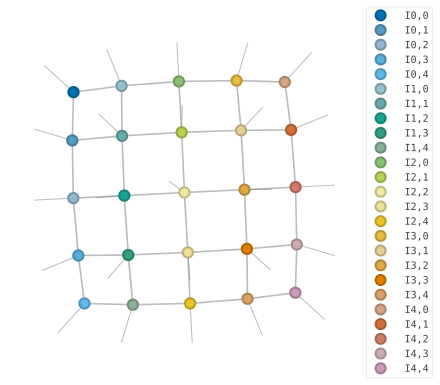

In [8]:
peps.draw(color=peps.site_tags)

In [9]:
norm = peps.H & peps
norm

<TensorNetwork2D(tensors=50, indices=105, Lx=5, Ly=5, max_bond=3)>

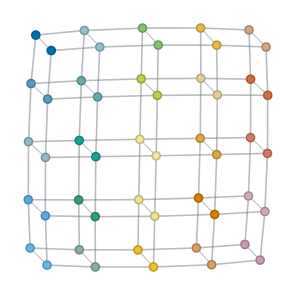

In [10]:
norm.draw(color=norm.site_tags, legend=False, figsize=(4, 4))

In [11]:
norm.contract(all, optimize='auto-hq')

0.5077521135992219

In [12]:
%%time
norm.contract_boundary(max_bond=32)

CPU times: user 869 ms, sys: 12 ms, total: 881 ms
Wall time: 122 ms


0.5069991787005163

By default `contract_boundary` also flattens the TN as it goes. 
If you want to do a multilayer boundary contraction you need to tag
the different layers and specify them:

In [13]:
peps.add_tag('KET')
pepsH = peps.conj().retag({'KET': 'BRA'})
norm = pepsH & peps

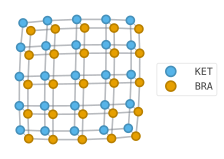

In [14]:
norm.draw(color=['KET', 'BRA'], figsize=(3, 3))

Now we can specify `layer_tags=['KET', 'BRA']` to any of the boundary 
contraction methods. Here we perform an inplace boundary contraction around
the sites `(2, 2)` and `(2, 3)`.

In [15]:
norm.contract_boundary_(max_bond=64, layer_tags=['KET', 'BRA'], around=((2, 2), (2, 3)))

<TensorNetwork2D(tensors=15, indices=29, Lx=5, Ly=5, max_bond=64)>

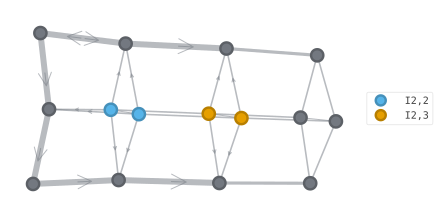

In [16]:
norm.draw(color=[norm.site_tag(2, 2), norm.site_tag(2, 3)], show_tags=False)

Note the tensors on the right haven't been flattened as they on the boundary already.

In [17]:
# two spin operator
H2 = qu.ham_heis(2)

# coordinates to act with operator on
coo_a = (2, 2)
coo_b = (2, 3)

# compute expectation
peps.compute_local_expectation(
    {(coo_a, coo_b): H2}, 
    max_bond=64,
    normalized=True, 
)

0.0004870786802366734

In [18]:
# compute the heisenberg interaction for every bond in the PEPS lattice
terms = {
    (coo_a, coo_b): H2
    for coo_a, coo_b in peps.gen_bond_coos()
}

peps.compute_local_expectation(
    terms, 
    max_bond=64,
    normalized=True, 
)

0.26752530504966554

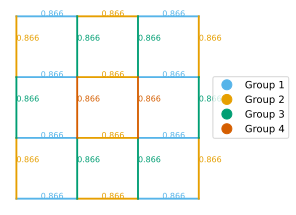

In [19]:
Lx = 4
Ly = 4

ham = qtn.LocalHam2D(Lx, Ly, H2=H2)
ham.draw()

The ``H2`` kwarg describes two site interactions. If an operator is given directly (as here)
it is used as a default term for all nearest neighbor interactions, as can be seen in the
visualization above.
We can also mix default single and two body terms and those for specific sites:

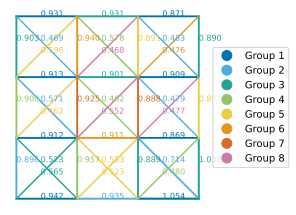

In [20]:
# the default two body term
H2 = {None: qu.ham_heis(2)}

# single site terms
H1 = {}

for i in range(Lx):
    for j in range(Ly):
        
        # add next nearest neighbor interactions
        if (i + 1 < Lx) and (j - 1 >= 0):
            H2[(i, j), (i + 1, j - 1)] = 0.5 * qu.ham_heis(2)
        if (i + 1 < Lx) and (j + 1 < Ly):
            H2[(i, j), (i + 1, j + 1)] = 0.5 * qu.ham_heis(2)
        
        # add a random field
        H1[i, j] = qu.randn() * qu.spin_operator('Z')
        
ham_nn_r = qtn.LocalHam2D(Lx, Ly, H2=H2, H1=H1)
ham_nn_r.draw()

In [21]:
peps.compute_local_expectation(ham_nn_r.terms, max_bond=32)

(0.11238897240206512+0j)

In the next few sections we'll try and find the groundstate of the 
4x4 Heisenberg lattice:

In [22]:
Lx = 4
Ly = 4

ham = qtn.LocalHam2D(Lx, Ly, H2=qu.ham_heis(2))

This is small enough to easily compute the exact groundstate energy:

In [23]:
energy_exact = qu.groundenergy(qu.ham_heis_2D(Lx, Ly, sparse=True)) / (Lx * Ly)
energy_exact

-0.5743254415745597

In [24]:
D = 4
psi0 = qtn.PEPS.rand(Lx, Ly, bond_dim=D, seed=666)

In [25]:
su = qtn.SimpleUpdate(
    psi0, 
    ham,
    chi=32,  # boundary contraction bond dim for computing energy
    compute_energy_every=10,
    compute_energy_per_site=True,
    keep_best=True,
)

In [26]:
for tau in [0.3, 0.1, 0.03, 0.01]:
    su.evolve(100, tau=tau)

n=400, tau=0.0100, energy~-0.562843: 100%|############################################| 100/100 [00:05<00:00, 18.23it/s]


The current state can be retrieved from `su.state`, or, if you have specified the
`keep_best` option, the lowest energy state seen can be found in `su.best['state']`.

In [27]:
su.best

{'energy': -0.5633772517149432,
 'state': <PEPS(tensors=16, indices=40, Lx=4, Ly=4, max_bond=4)>,
 'it': 110}

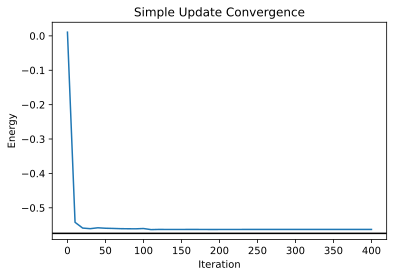

In [28]:
from matplotlib import pyplot as plt

plt.plot(su.its, su.energies)
plt.axhline(energy_exact, color='black')
plt.title('Simple Update Convergence')
plt.ylabel('Energy')
plt.xlabel('Iteration');

In [29]:
# use the best SU state as the starting point for FU
psi0 = su.best['state'].copy()

The way these algorithms are written using 
[autoray](https://github.com/jcmgray/autoray) means that we can convert
the backend arrays of our PEPS and Hamiltonian to e.g. GPU arrays and
everything should still run smoothly.

In the following (optional) cell, we convert to the arrays to single
precision ``cupy`` arrays, since FU is a good candidate for GPU acceleration.

In [30]:
def to_backend(x):
    import cupy as cp
    return cp.asarray(x).astype('float32')

psi0.apply_to_arrays(to_backend)
ham.apply_to_arrays(to_backend)

In [31]:
fu = qtn.FullUpdate(
    psi0=psi0,
    ham=ham,
    # chi again is the boundary contraction max_bond
    # now used for the envs as well as any energy calc
    chi=32,
    # we thus can cheaply compute the energy at every step
    compute_energy_every=1,
    compute_energy_per_site=True,
    keep_best=True,
)

In [32]:
fu.evolve(50, tau=0.1)

n=50, tau=0.1000, energy~-0.572248: 100%|###############################################| 50/50 [01:04<00:00,  1.30s/it]


In [33]:
fu.evolve(50, tau=0.03)

n=100, tau=0.0300, energy~-0.573131: 100%|##############################################| 50/50 [00:54<00:00,  1.10s/it]


In [34]:
fu.evolve(50, tau=0.01)

n=150, tau=0.0100, energy~-0.573359: 100%|##############################################| 50/50 [00:51<00:00,  1.04s/it]


We can see we have improved on the SU groundstate significantly.

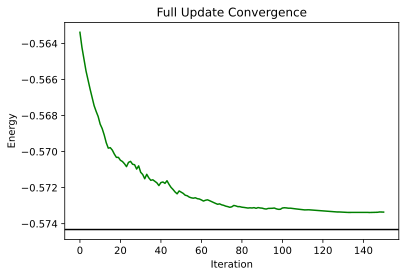

In [35]:
plt.plot(fu.its, fu.energies, color='green')
plt.axhline(energy_exact, color='black')
plt.title('Full Update Convergence')
plt.ylabel('Energy')
plt.xlabel('Iteration');

Full Update has many options relating to the fitting of the imaginary 
time evolution gates, controlling tradeoff between efficiency 
and accuracy, you can view them like so:

In [36]:
fu.fit_opts

{'tol': 1e-10,
 'steps': 20,
 'init_simple_guess': True,
 'condition_tensors': True,
 'condition_maintain_norms': True,
 'als_dense': True,
 'als_solver': 'solve',
 'als_enforce_pos': False,
 'als_enforce_pos_smudge': 1e-06,
 'autodiff_backend': 'autograd',
 'autodiff_optimizer': 'L-BFGS-B'}

For example, the following might be helpful to converge to very high accuracy:

In [37]:
fu.fit_opts['als_enforce_pos'] = True

In [38]:
Lx = Ly = 4
psi0 = qtn.PEPS.rand(Lx, Ly, bond_dim=4)
ham = qtn.LocalHam2D(Lx, Ly, H2=qu.ham_heis(2))

def loss(psi, terms):
    # the following functions simply scale the various tensors
    #     for the sake of numerical stability
    psi.balance_bonds_()
    psi.equalize_norms_(1.0)
    
    # then we just compute the energy of all the terms
    return psi.compute_local_expectation(
        terms,
        max_bond=32,
        cutoff=0.0,
        normalized=True
    ) / (Lx * Ly)

In [39]:
tnopt = qtn.TNOptimizer(
    # initial TN to optimize
    psi0,                                 
    # the function to minimize
    loss_fn=loss,                         
    # constant TNs, tensors, arrays
    loss_constants={'terms': ham.terms},  
    # the library that computes the gradient
    autodiff_backend='jax',               
    # the scipy optimizer that makes use of the gradient
    optimizer='L-BFGS-B',                 
)

The first step might be slow (e.g. with ``'jax'``) as it compiles the whole 
energy and gradient computation:

In [40]:
tnopt.optimize(1)

-0.116123460233 [best: -0.116123460233] : : 2it [00:26, 13.31s/it]                                                      


<PEPS(tensors=16, indices=40, Lx=4, Ly=4, max_bond=4)>

Subsequent optimization steps should be very quick, especially on a GPU:

In [41]:
psi_opt = tnopt.optimize(999)

-0.574246525764 [best: -0.574246525764] :  36%|██████████████▏                        | 363/999 [00:53<01:32,  6.84it/s]


We can then check the convergence:

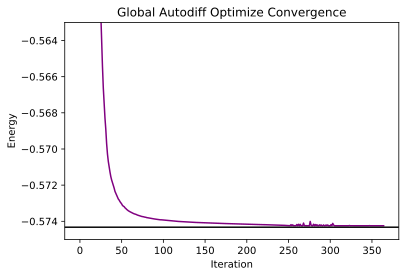

In [42]:
plt.plot(tnopt.losses, color='purple')
plt.axhline(energy_exact, color='black')
plt.title('Global Autodiff Optimize Convergence')
plt.ylabel('Energy')
plt.ylim(-0.575, -0.563)
plt.xlabel('Iteration');

In [43]:
psi_opt.compute_local_expectation(
    ham.terms, normalized=True, max_bond=100
) / (Lx * Ly)

-0.5741325192483877